Co-authorship network is a group of researchers connected in pairs to represent relationships. Two researchers are considered related when they have published papers in journals and conferences and published and edited books together. In such networks, researchers are called "nodes" or "nodes", and connections are called "edges". Co-authorship networks are an important class of social networks. Analysis of these networks reveals characteristics of academic communities that contribute to understanding collaboration and identifying prominent researchers.

The focus of this notebook is to analysis of structural properties in co-authored networks in a given field of study

In [1]:
!pip install pyvis
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.0 MB/s eta 0:00:00a 0:00:01


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import sys
import ast

import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

import dask.bag as db

import networkx as nx
from networkx.algorithms.components.connected import connected_components

import json
import dask.bag as db
import os

sys.path.append("..")

from pathlib import Path

import json

from itertools import combinations
from collections import Counter
from itertools import chain
import random

from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations

import multiprocessing
import smart_open

from gensim.models.word2vec import Word2Vec

import pyvis

from pyvis.network import Network

from IPython.core.display import display, HTML

/var/folders/hn/p77x1w5x5s725x1wyvhfn59h0000gn/T/ipykernel_8069/3495327860.py:44: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [56]:
ai_category_list=['cs.CR']
records=db.read_text("./arxiv-metadata-oai-snapshot.json").map(lambda x:json.loads(x))
ai_docs = (records.filter(lambda x:any(ele in x['categories'] for ele in ai_category_list)==True))
get_metadata = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'],
                  'abstract':x['abstract'],
                 'version':x['versions'][-1]['created'],
                         'doi':x["doi"],
                         'authors_parsed':x['authors_parsed']}

data=ai_docs.map(get_metadata).to_dataframe().compute()

data.to_excel("Astro_ArXiv_Papers.xlsx",index=False)

In [57]:
# Concatenate the author first and last names
data['num_authors']=data['authors_parsed'].apply(lambda x:len(x))

data['authors']=data['authors_parsed'].apply(lambda authors:[(" ".join(author)).strip() for author in authors])
data.head()

,id,title,category,abstract,version,doi,authors_parsed,num_authors,authors
0,0704.0492,Refuting the Pseudo Attack on the REESSE1+ Cry...,cs.CR,We illustrate through example 1 and 2 that t...,"Thu, 4 Feb 2010 14:06:43 GMT",None,"[[Su, Shenghui, ], [Lu, Shuwang, ]]",2,"[Su Shenghui, Lu Shuwang]"
1,0704.0858,Lessons Learned from the deployment of a high-...,cs.CR,This paper presents an experimental study an...,"Fri, 6 Apr 2007 08:22:50 GMT",None,"[[Alata, Eric, , LAAS], [Nicomette, Vincent, ,...",5,"[Alata Eric LAAS, Nicomette Vincent LAAS, Ka..."
2,0704.0861,Empirical analysis and statistical modeling of...,cs.PF cs.CR,Honeypots are more and more used to collect ...,"Fri, 6 Apr 2007 08:50:34 GMT",None,"[[Kaaniche, Mohamed, , LAAS], [Deswarte, Y., ,...",5,"[Kaaniche Mohamed LAAS, Deswarte Y. LAAS, Al..."
3,0704.2259,The Wiretap Channel with Feedback: Encryption ...,cs.IT cs.CR math.IT,"In this work, the critical role of noisy fee...","Wed, 18 Apr 2007 02:43:40 GMT",10.1109/TIT.2008.929914,"[[Lai, Lifeng, ], [Gamal, Hesham El, ], [Poor,...",3,"[Lai Lifeng, Gamal Hesham El, Poor H. Vincent]"
4,0704.2295,Using Image Attributes for Human Identificatio...,cs.CR,A secure human identification protocol aims ...,"Wed, 18 Apr 2007 09:13:43 GMT",None,"[[Jameel, Hassan, ], [Lee, Heejo, ], [Lee, Sun...",3,"[Jameel Hassan, Lee Heejo, Lee Sungyoung]"


In [58]:
data['DateTime']=pd.to_datetime(data['version'])
data['Day'] = data['DateTime'].dt.day
data['Month'] = data['DateTime'].dt.month
data['Year'] = data['DateTime'].dt.year

In [59]:
# Filter data (2020 to 2021)

data = data[data['Year'].between(2020, 2021)]

In [60]:
# This project focuses on individual author structure and development;
data = data[data['num_authors'] <= 6]

In [61]:
data['author_pairs']=data['authors'].apply(lambda x:list(combinations(x, 2)))

In [62]:
def flattenList(nested_list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list

In [63]:
astro_authors=pd.DataFrame(flattenList(data['authors'].tolist())).rename(columns={0:'authors'})
papers_by_authors=astro_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors.shape

(15169, 2)

In [64]:
papers_by_authors['Number of Papers Published'].describe()

count    15169.000000
mean         1.560749
std          1.437569
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         29.000000
Name: Number of Papers Published, dtype: float64

In [65]:
# Keeping Authors who have published more than 2 Papers
nodes_to_keep=papers_by_authors.loc[papers_by_authors['Number of Papers Published']>2,'authors'].tolist()
len(nodes_to_keep)

1757

## Generating the Edges of the Co-Author Network

In [66]:
authors_pairs=data['author_pairs'].tolist()
authors_edge_list=[item for sublist in authors_pairs for item in sublist]
authors_weighted_edge_list=list(Counter(authors_edge_list).items())
authors_weighted_edge_list=[(row[0][0],row[0][1],row[1]) for idx,row in enumerate(authors_weighted_edge_list)]
authors_weighted_edge_list[0:10]

[('Li Qin', 'Li Chengqing', 1),
 ('Li Qin', 'Wu Chunhui', 1),
 ('Li Qin', 'Long Dongyang', 1),
 ('Li Qin', 'Wang Changji', 1),
 ('Li Chengqing', 'Wu Chunhui', 1),
 ('Li Chengqing', 'Long Dongyang', 1),
 ('Li Chengqing', 'Wang Changji', 1),
 ('Wu Chunhui', 'Long Dongyang', 1),
 ('Wu Chunhui', 'Wang Changji', 1),
 ('Long Dongyang', 'Wang Changji', 1)]

In [67]:
G1=nx.Graph()
G1.add_weighted_edges_from(authors_weighted_edge_list)
print(len(G1.nodes()))

14910


In [68]:
sub_g=nx.subgraph(G1,nodes_to_keep)
G=nx.Graph(sub_g)
print(len(G.nodes()))
isolated_node=nx.isolates(G)
len(list(isolated_node))

1747


145

In [69]:
G.remove_nodes_from(list(nx.isolates(G)))
len(G.nodes)

1602

In [70]:
del G1, sub_g

In [71]:
print("Number of Nodes in Author Graph ",len(G.nodes()))
print("Number of Edges in AUthor Graph ",len(G.edges()))

Number of Nodes in Author Graph  1602
Number of Edges in AUthor Graph  2769


In [72]:
def getRandomWalk(graph,node,length_of_random_walk):
    start_node=node
    current_node=start_node
    random_walk=[node]
    for i in range(0,length_of_random_walk):
        current_node_neighbours=list(graph.neighbors(current_node))
        chosen_node=random.choice(current_node_neighbours)
        current_node=chosen_node
        random_walk.append(current_node)
    return random_walk

#### For every Node in the Graph, get randomwalks .
#### For each node, get 10 random walks

In [73]:
num_sampling=10
random_walks=[]
length_of_random_walk=10
for node in tqdm(G.nodes(),desc="Iterating Nodes"):

    for i in range(0,num_sampling):
        random_walks.append(getRandomWalk(G,node,length_of_random_walk))

/Users/fox/anaconda3/envs/dl/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/Users/fox/anaconda3/envs/dl/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/Users/fox/anaconda3/envs/dl/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/Users/fox/anaconda3/envs/dl/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the 

Iterating Nodes:   0%|          | 0/1602 [00:00<?, ?it/s]

In [74]:
deepwalk_model=Word2Vec(sentences=random_walks,window=5,sg=1,negative=5,vector_size=128,epochs=20,compute_loss=True)

In [75]:
deepwalk_model.save("deepwalk1.model")

In [76]:
def getSimilarNodes(model,node):
    similarity=model.wv.most_similar(node)
    similar_nodes=pd.DataFrame()
    similar_nodes['Similar_Node']=[row[0] for i,row in enumerate(similarity)]
    similar_nodes['Similarity_Score']=[row[1] for i,row in enumerate(similarity)]
    similar_nodes['Source_Node']=node
    return similar_nodes

In [77]:
ai_authors=pd.DataFrame(flattenList(data['authors'].tolist())).rename(columns={0:'authors'})
papers_by_authors=ai_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors

,authors,Number of Papers Published
7546,Liu Yang,29
4195,Gong Neil Zhenqiang,26
3288,Elovici Yuval,23
11258,Shabtai Asaf,21
11481,Shiaeles Stavros,21
...,...,...
5791,Jääger Joosep,1
5793,Jørgensen Jonas Kofod,1
5795,Júnior Elvandi da Silva,1
5796,K Buvanasri A,1


In [78]:
def getCoAuthorshipNetwork(graph,initial_nodes):
    total_neighbours=0
    nodes_set=[initial_nodes]
    for node in initial_nodes:
        #print(node)
        neighbours=list(graph.neighbors(node))
        total_neighbours=total_neighbours+len(neighbours)

        nodes_set.append(neighbours)
    print(total_neighbours)
    nodes_set=flattenList(nodes_set)
    return list(set(nodes_set))

In [79]:
coauthor_nodes=getCoAuthorshipNetwork(G,papers_by_authors['authors'].tolist()[4:10])
print("Number of CoAuthor Nodes ",len(coauthor_nodes))

67
Number of CoAuthor Nodes  64


In [80]:
coauthor_subgraph=nx.subgraph(G,coauthor_nodes)
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  134


In [81]:
nx.write_gexf(coauthor_subgraph, "CoAuthor_Subgraph_Author4to10.gexf")

In [82]:
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  134


In [83]:
pyvis_nt=Network(notebook=True,height='800px', width='100%',heading='')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)

print("Saving PyVis Graph")
pyvis_nt.show("Author4to10_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph
Author4to10_CoAuthorGraph.html


## Degree Centrality
The degtee of a node is the number oof other nodes to which it is connected
It is calculated by taking the degree of the node and dividing by n-1 where n is the number of nodes in G

In [84]:
degree_centrality = nx.degree_centrality(G)

In [85]:
# Top 10
counter = 0
for w in sorted(degree_centrality, key = degree_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 21:
        break
    print(w,"{:0.5f}".format(degree_centrality[w]))

Liu Yang 0.01624
Nepal Surya 0.01624
Wang Wei 0.01187
Thakurta Abhradeep 0.01187
Papernot Nicolas 0.01124
Jha Somesh 0.01062
Li Bo 0.00937
Zhang Yang 0.00874
Jurdak Raja 0.00874
Lyu Lingjuan 0.00812
Zhao Jun 0.00812
Livshits Benjamin 0.00812
Gong Neil Zhenqiang 0.00750
Biggio Battista 0.00750
Wang Hao 0.00750
Mireshghallah Fatemehsadat 0.00750
Carlini Nicholas 0.00750
Kamath Gautam 0.00750
Wu Zhiwei Steven 0.00750
Raskar Ramesh 0.00687


# Closeness Centrality
Closeness centrality measures the mean distance from one node to any other node. The more central a node is, the closer it is to all the other nodes. The closeness of a node is typically referred to in its normalized form

In [86]:
closeness_centrality = nx.closeness_centrality(G)

In [87]:
# Top 10
counter = 0
for w in sorted(closeness_centrality, key = closeness_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 23:
        break
    print(w,"{:0.5f}".format(closeness_centrality[w]))

Li Bo 0.12340
Liu Yang 0.12140
Oprea Alina 0.11517
Wang Wei 0.11435
Jagielski Matthew 0.11405
Nepal Surya 0.11359
Xue Minhui 0.11340
Biggio Battista 0.11124
Zhao Jun 0.11124
Nita-Rotaru Cristina 0.11107
Liu Ximeng 0.11063
Zhu Tianqing 0.11026
Zhao Benjamin Zi Hao 0.10938
Gunter Carl A. 0.10864
Wang Qi 0.10849
Ranasinghe Damith C. 0.10845
Shabtai Asaf 0.10791
Ma Jianfeng 0.10776
Camtepe Seyit 0.10770
Lyu Lingjuan 0.10717
Meng Guozhu 0.10688
Chen Shiping 0.10561


node Mukherjee Suvodip as the highest closeness centrality, which means that it is closest to the most nodes than all the other nodes.

# Betweenness Centrality
It quantifies the number of times a node acts as a bridge along the shortest path between two other nodes
In thids conception, vectices that have a high probability to occur on a randomly chosen shortest path between two randomly chosen verticles have a high betweenness

In [88]:
betweenness_centrality = nx.betweenness_centrality(G)

In [89]:
# Top 10
counter = 0
for w in sorted(betweenness_centrality, key = betweenness_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 23:
        break
    print(w,"{:0.5f}".format(betweenness_centrality[w]))

Li Bo 0.08846
Liu Yang 0.07958
Nepal Surya 0.05021
Wang Wei 0.04073
Jagielski Matthew 0.03483
Choo Kim-Kwang Raymond 0.03334
Haddadi Hamed 0.03311
Ullman Jonathan 0.02988
Demetriou Soteris 0.02808
Oprea Alina 0.02799
Zhao Jun 0.02567
Jha Somesh 0.02480
Mahloujifar Saeed 0.02415
Liu Ximeng 0.02215
Biggio Battista 0.02164
Vadhan Salil 0.02094
Gunter Carl A. 0.02061
Konstantinou Charalambos 0.02060
Zhu Tianqing 0.02059
Jha Sanjay 0.02052
Lyu Lingjuan 0.02040
Conti Mauro 0.01999


# Eigenvector Centrality
A node is high in eigenvector centrality if it is connected to many other nodes who are themselves well connected.
Eigenvector centrality for each node is simply calculated as the proportional eigenvector values of the eigenvector with the largest eigenvector

In [90]:
eigenvector_centrality = nx.eigenvector_centrality(G,max_iter=500)

In [91]:
# Top 10
counter = 0
for w in sorted(eigenvector_centrality, key = eigenvector_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 23:
        break
    print(w,"{:0.5f}".format(eigenvector_centrality[w]))

Thakurta Abhradeep 0.38949
Carlini Nicholas 0.29425
Papernot Nicolas 0.27006
Jha Somesh 0.25385
Song Shuang 0.24842
Mironov Ilya 0.21385
Mahloujifar Saeed 0.19481
Erlingsson Úlfar 0.18806
Mahmoody Mohammad 0.17527
Garg Sanjam 0.17527
Nasr Milad 0.16664
Tramer Florian 0.16255
Raghunathan Ananth 0.16197
Feldman Vitaly 0.14784
Talwar Kunal 0.14587
Thakkar Om 0.14204
Steinke Thomas 0.13624
Kairouz Peter 0.12113
Jagielski Matthew 0.11976
Chandrasekaran Varun 0.11141
Roth Aaron 0.09919
Tramèr Florian 0.09818


In [103]:
Silk_nodes = getCoAuthorshipNetwork(G,['Carlini Nicholas'])
Silk_network = nx.subgraph(G,Silk_nodes)
print("Number of Nodes in Carlini Network ", len(Silk_network.nodes()))
print("Number of Edges in Carlini Network ", len(Silk_network.edges()))

12
Number of Nodes in Carlini Network  13
Number of Edges in Carlini Network  39


In [104]:
cdn_resources='in_line'

In [105]:
Silk_nt=Network(notebook=True,height='800px', width='100%',heading='Silk Network')

print("Creating PyVis from NetworkX")
Silk_nt.from_nx(Silk_network)
Silk_nt.toggle_physics(True)
print("Saving PyVis Graph")

Silk_nt.show_buttons()
Silk_nt.show("Silk_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph
Silk_CoAuthorGraph.html


In [106]:
data['is_SJ']=data['authors'].apply(lambda x:1 if "Carlini Nicholas" in x else 0)
SJ_papers=data[data['is_SJ']==1]
SJ_papers=SJ_papers.reset_index(drop=True)

print("Number of Papers by Carlini Nicholas on Arxiv is ",SJ_papers.shape[0])

Number of Papers by Carlini Nicholas on Arxiv is  11


In [108]:
print("The First Paper published by Carlini Nicholas was in ",min(SJ_papers['DateTime']))
print("The Recent Paper published by Carlini Nicholas was in  ",max(SJ_papers['DateTime']))

The First Paper published by Carlini Nicholas was in  2020-03-03 22:08:02
The Recent Paper published by Carlini Nicholas was in   2021-12-05 22:45:19


In [109]:
import nltk
from nltk.corpus import stopwords

In [110]:
def removeStopWords(text,stop_words):
    words=text.split()
    filtered_words=[word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [111]:
titles=SJ_papers['title'].tolist()
stop_words = set(stopwords.words('english'))
titles=[title.lower() for title in titles] ### Lower Casing the Title
titles=[removeStopWords(title,stop_words) for title in titles]

In [112]:
def generateNGram(text,n=2):
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    n_grams= ["_".join(ngram) for ngram in ngrams]
    n_grams=[ngram for ngram in n_grams if not ngram.startswith("_")]
    n_grams=[ngram for ngram in n_grams if not ngram.endswith("_")]
    return n_grams

def getMostCommon(reviews_list,topn=20):
    reviews=" ".join(reviews_list)
    tokenised_reviews=reviews.split(" ")
    freq_counter=Counter(tokenised_reviews)
    return freq_counter.most_common(topn)

In [119]:
bigrams_list=[" ".join(generateNGram(title,2)) for title in titles]
topn=10
top_bigrams=getMostCommon(bigrams_list,topn=topn)
top_bigrams_df=pd.DataFrame()
top_bigrams_df['words']=[val[0] for val in top_bigrams]
top_bigrams_df['Frequency']=[val[1] for val in top_bigrams]
px.bar(data_frame=top_bigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Bigrams in Papers published by Carlini Nicholas")

In [120]:
trigrams_list=[" ".join(generateNGram(title.replace(":",""),3)) for title in titles]
topn=10
top_trigrams=getMostCommon(trigrams_list,topn=topn)
top_trigrams_df=pd.DataFrame()
top_trigrams_df['words']=[val[0] for val in top_trigrams]
top_trigrams_df['Frequency']=[val[1] for val in top_trigrams]
top_trigrams_df=top_trigrams_df[top_trigrams_df["words"]!=""]
px.bar(data_frame=top_trigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Trigrams in Papers published by Carlini Nicholas")

In [121]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis

In [122]:
def tokenise(sentences):
    return [gensim.utils.simple_preprocess(sentence, deacc=True,max_len=50) for sentence in sentences]

In [123]:
tokenised_sentences=tokenise(SJ_papers['title'].tolist())
tokenised_sentences[0]

['high',
 'accuracy',
 'and',
 'high',
 'fidelity',
 'extraction',
 'of',
 'neural',
 'networks']

In [126]:
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [127]:
def lemmatise(sentence,stop_words,allowed_postags=None):
    doc=nlp(sentence)
    #print(sentence)
    if allowed_postags!=None:
        tokens = [token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (token.text not in stop_words)]
    if allowed_postags==None:
        tokens= [token.lemma_ for token in doc if (token.text not in stop_words)]
    return tokens

In [128]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [129]:
sentences=[" ".join(tokenised_sentence) for tokenised_sentence in tokenised_sentences]
lemmatised_sentences=[lemmatise(sentence,stop_words) for sentence in sentences]
lemmatised_sentences[0]

['high', 'accuracy', 'high', 'fidelity', 'extraction', 'neural', 'network']

In [130]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(lemmatised_sentences,min_count=2)
trigram = gensim.models.Phrases(bigram[lemmatised_sentences],min_count=2)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [131]:
bigrams_words=[bigram_mod[sentence] for sentence in lemmatised_sentences]

trigrams_words=[trigram_mod[sentence] for sentence in bigrams_words]

In [132]:
id2word = corpora.Dictionary(trigrams_words)
corpus = [id2word.doc2bow(text) for text in trigrams_words]
[(id2word[id], freq) for id, freq in corpus[0]]

[('accuracy', 1),
 ('extraction', 1),
 ('fidelity', 1),
 ('high', 2),
 ('network', 1),
 ('neural', 1)]

In [133]:
def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

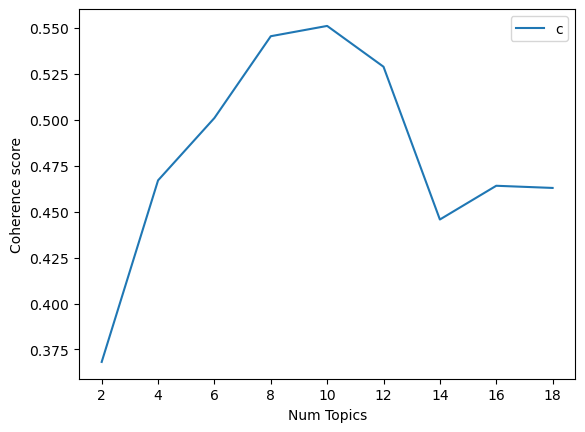

In [134]:
models,coherence=compute_coherence_values(id2word,corpus,trigrams_words,limit=20,start=2,step=2)
x = range(2, 20, 2)
plt.plot(x, coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [135]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [136]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.063*"adversarial" + 0.049*"defense" + 0.035*"high" + 0.035*"neural" + '
  '0.035*"extraction" + 0.035*"network" + 0.035*"attack" + 0.035*"example" + '
  '0.021*"evade" + 0.021*"fidelity"'),
 (1,
  '0.052*"attack" + 0.051*"private" + 0.031*"adversary" + 0.031*"machine" + '
  '0.031*"bound" + 0.031*"label" + 0.031*"learn" + 0.031*"inference" + '
  '0.031*"differentially" + 0.031*"low"')]


In [137]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=trigrams_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.3608459776906825

Coherence Score:  0.36822047277976977


In [138]:
def format_topics_sentences(texts,ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [139]:
df_topic_sents_keywords = format_topics_sentences(SJ_papers['title'].tolist(),ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
topic_counts=df_dominant_topic['Dominant_Topic'].value_counts().reset_index().rename(columns={'index':'Topic','Dominant_Topic':'Number of Documents'})
topic_counts['percentage_contribution']=(topic_counts['Number of Documents']/topic_counts['Number of Documents'].sum())*100
topic_counts

In [ ]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

    return terms

In [ ]:
num_topics=2

topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
    topic_summaries += [tmp[:5]]
    print

In [ ]:
# topic weights and dominant topics
from sklearn.manifold import TSNE


# topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values


# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

In [ ]:
sent_topics_df=pd.DataFrame()
sent_topics_df['Text']=SJ_papers['title'].tolist()
sent_topics_df['tsne_x']=tsne_lda[:,0]
sent_topics_df['tsne_y']=tsne_lda[:,1]
sent_topics_df['Topic_No']=topic_num
sent_topics_df=pd.merge(sent_topics_df,df_dominant_topic,on="Text")
sent_topics_df.head()

In [ ]:
px.scatter(x='tsne_x',y='tsne_y',data_frame=sent_topics_df,color="Topic_No",hover_data=["Topic_Perc_Contrib"])

In [ ]:
Fabian_nodes = getCoAuthorshipNetwork(G,['Fabian A. C.'])
Fabian_network = nx.subgraph(G,Fabian_nodes)
print("Number of Nodes in Fabian Network ", len(Fabian_network.nodes()))
print("Number of Edges in Fabian Network ", len(Fabian_network.edges()))

In [ ]:
Fabian_nt=Network(notebook=True,height='800px', width='100%',heading='Fabian Network')

print("Creating PyVis from NetworkX")
Fabian_nt.from_nx(Fabian_network)
Fabian_nt.toggle_physics(True)
print("Saving PyVis Graph")

Fabian_nt.show_buttons()
Fabian_nt.show("Fabian_CoAuthorGraph.html")

In [ ]:
data['is_FA']=data['authors'].apply(lambda x:1 if "Fabian A. C." in x else 0)
FA_papers=data[data['is_FA']==1]
FA_papers=FA_papers.reset_index(drop=True)

print("Number of Papers by Fabian A. C. on Arxiv is ",FA_papers.shape[0])

In [ ]:
print("The First Paper published by Fabian A. C. was in ",min(FA_papers['DateTime']))
print("The Recent Paper published by Fabian A. C. was in  ",max(FA_papers['DateTime']))

In [ ]:
titles=FA_papers['title'].tolist()
stop_words = set(stopwords.words('english'))
titles=[title.lower() for title in titles] ### Lower Casing the Title
titles=[removeStopWords(title,stop_words) for title in titles]

In [ ]:
bigrams_list=[" ".join(generateNGram(title,2)) for title in titles]
topn=10
top_bigrams=getMostCommon(bigrams_list,topn=topn)
top_bigrams_df=pd.DataFrame()
top_bigrams_df['words']=[val[0] for val in top_bigrams]
top_bigrams_df['Frequency']=[val[1] for val in top_bigrams]
px.bar(data_frame=top_bigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Bigrams in Papers published by Fabian A.C.")

In [ ]:
trigrams_list=[" ".join(generateNGram(title.replace(":",""),3)) for title in titles]
topn=10
top_trigrams=getMostCommon(trigrams_list,topn=topn)
top_trigrams_df=pd.DataFrame()
top_trigrams_df['words']=[val[0] for val in top_trigrams]
top_trigrams_df['Frequency']=[val[1] for val in top_trigrams]
top_trigrams_df=top_trigrams_df[top_trigrams_df["words"]!=""]
px.bar(data_frame=top_trigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Trigrams in Papers published by Fabian A.C.")

In [ ]:
tokenised_sentences=tokenise(FA_papers['title'].tolist())
tokenised_sentences[0]

In [ ]:
sentences=[" ".join(tokenised_sentence) for tokenised_sentence in tokenised_sentences]
lemmatised_sentences=[lemmatise(sentence,stop_words) for sentence in sentences]
lemmatised_sentences[0]

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(lemmatised_sentences,min_count=2)
trigram = gensim.models.Phrases(bigram[lemmatised_sentences],min_count=2)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
bigrams_words=[bigram_mod[sentence] for sentence in lemmatised_sentences]

trigrams_words=[trigram_mod[sentence] for sentence in bigrams_words]

In [ ]:
id2word = corpora.Dictionary(trigrams_words)
corpus = [id2word.doc2bow(text) for text in trigrams_words]
[(id2word[id], freq) for id, freq in corpus[0]]

In [ ]:
models,coherence=compute_coherence_values(id2word,corpus,trigrams_words,limit=20,start=2,step=2)
x = range(2, 20, 2)
plt.plot(x, coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=trigrams_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(FA_papers['title'].tolist(),ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
topic_counts=df_dominant_topic['Dominant_Topic'].value_counts().reset_index().rename(columns={'index':'Topic','Dominant_Topic':'Number of Documents'})
topic_counts['percentage_contribution']=(topic_counts['Number of Documents']/topic_counts['Number of Documents'].sum())*100
topic_counts

In [ ]:
num_topics=2

topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
    topic_summaries += [tmp[:5]]
    print

In [ ]:
# topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values


# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

In [ ]:
sent_topics_df=pd.DataFrame()
sent_topics_df['Text']=FA_papers['title'].tolist()
sent_topics_df['tsne_x']=tsne_lda[:,0]
sent_topics_df['tsne_y']=tsne_lda[:,1]
sent_topics_df['Topic_No']=topic_num
sent_topics_df=pd.merge(sent_topics_df,df_dominant_topic,on="Text")
sent_topics_df.head()

In [ ]:
px.scatter(x='tsne_x',y='tsne_y',data_frame=sent_topics_df,color="Topic_No",hover_data=["Topic_Perc_Contrib"])